# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re # Regular expressions for cleaning
import time

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
import lightgbm as lgb

# Configuration

In [2]:
RANDOM_STATE = 42 # for reproducibility
N_TOP_FEATURES = 25 # Number of top features to display
TEST_SIZE = 0.2 # Hold out 20% of the sampled data for testing

# 1. Load Data

In [3]:
print(f"Loading FULL dataset...")
file_path = '/kaggle/input/us-used-cars-dataset/used_cars_data.csv'

# Load header to get column names
try:
    df_raw = pd.read_csv(file_path, low_memory=False)
    print(f"Full data loaded successfully. Shape: {df_raw.shape}")

    print("Optimizing data types...")
    # Downcast floats
    float_cols = df_raw.select_dtypes(include=['float64']).columns
    for col in float_cols:
        df_raw[col] = pd.to_numeric(df_raw[col], downcast='float')

    # Downcast integers where possible
    int_cols = df_raw.select_dtypes(include=['int64']).columns
    for col in int_cols:
        df_raw[col] = pd.to_numeric(df_raw[col], downcast='integer') # Or 'unsigned' if applicable


    print(f"Memory usage after optimization: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

except Exception as e:
    print(f"Error loading or optimizing data: {e}")
    raise SystemExit("Data loading/optimization failed.")

# Create a working copy
df = df_raw.copy()

Loading FULL dataset...
Full data loaded successfully. Shape: (3000040, 66)
Optimizing data types...
Memory usage after optimization: 15798.26 MB


# 2. Initial Cleaning and Feature Selection 

In [4]:
print("\n--- Initial Cleaning and Feature Selection ---")

# Drop columns identified with >2M NaNs in the full dataset (based on the EDA)
high_nan_cols = [
    'bed', 'bed_height', 'bed_length', 'cabin', 'combine_fuel_economy',
    'is_certified', 'is_cpo', 'is_oemcpo', 'vehicle_damage_category'
]
# Drop other columns unlikely to be useful or too problematic
other_cols_to_drop = [
    'vin', 'listing_id', 'trimId', 'sp_id', # Identifiers
    'description', # Free text
    'main_picture_url', # URL
    'dealer_zip', # High cardinality, city/lat/long might be better proxies if kept
    'city', # High cardinality
    'latitude', 'longitude', # Location (can add complexity)
    'listed_date', # Use daysonmarket instead
    'sp_name', # High cardinality dealer name
    'franchise_make', # make_name is likely sufficient
    'transmission_display', # Redundant with transmission
    'wheel_system_display', # Redundant with wheel_system
    'power', # Requires complex parsing (e.g., '200 hp @ 5000 rpm') - horsepower is direct
    'torque', # Requires complex parsing
    'major_options', # Requires complex parsing/NLP
]

columns_to_drop = high_nan_cols + other_cols_to_drop
# Ensure columns exist in the dataframe before dropping
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

df.drop(columns=columns_to_drop, inplace=True)
print(f"Dropped {len(columns_to_drop)} columns.")
print(f"Shape after dropping columns: {df.shape}")
print("Remaining columns:", df.columns.tolist())


--- Initial Cleaning and Feature Selection ---
Dropped 27 columns.
Shape after dropping columns: (3000040, 39)
Remaining columns: ['back_legroom', 'body_type', 'city_fuel_economy', 'daysonmarket', 'engine_cylinders', 'engine_displacement', 'engine_type', 'exterior_color', 'fleet', 'frame_damaged', 'franchise_dealer', 'front_legroom', 'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height', 'highway_fuel_economy', 'horsepower', 'interior_color', 'isCab', 'is_new', 'length', 'listing_color', 'make_name', 'maximum_seating', 'mileage', 'model_name', 'owner_count', 'price', 'salvage', 'savings_amount', 'seller_rating', 'theft_title', 'transmission', 'trim_name', 'wheel_system', 'wheelbase', 'width', 'year']


# 3. Target Variable Cleaning (Price)

In [5]:
print("\n--- Cleaning Target Variable (Price) ---")
if 'price' not in df.columns:
     raise ValueError("Target variable 'price' not found in the loaded columns.")

print(f"Price stats before cleaning:\n{df['price'].describe()}")
# Check for non-numeric prices (if loaded as object)
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df.dropna(subset=['price'], inplace=True) # Remove rows where price became NaN
df['price'] = df['price'].astype(float) # Ensure it's float

# Define reasonable price bounds. Using percentiles is robust.
price_upper_bound = df['price'].quantile(0.995) # Remove top 0.5%
price_lower_bound = 500 # Remove listings below $500
print(f"Removing prices below ${price_lower_bound} and above ${price_upper_bound:.2f} (99.5th percentile)")
df = df[(df['price'] >= price_lower_bound) & (df['price'] <= price_upper_bound)]
print(f"Shape after price cleaning: {df.shape}")
print(f"Price stats after cleaning:\n{df['price'].describe()}")



--- Cleaning Target Variable (Price) ---
Price stats before cleaning:
count    3.000040e+06
mean     2.993337e+04
std      1.956617e+04
min      1.650000e+02
25%      1.845100e+04
50%      2.647700e+04
75%      3.822000e+04
max      3.299995e+06
Name: price, dtype: float64
Removing prices below $500 and above $102995.00 (99.5th percentile)
Shape after price cleaning: (2984957, 39)
Price stats after cleaning:
count    2.984957e+06
mean     2.929104e+04
std      1.554869e+04
min      5.000000e+02
25%      1.839000e+04
50%      2.636600e+04
75%      3.799500e+04
max      1.029950e+05
Name: price, dtype: float64


# 4. Feature Engineering

In [6]:
print("\n--- Feature Engineering ---")
# Create 'car_age' from 'year'
if 'year' in df.columns:
    # Fill potential NaNs in 'year' before calculating age
    median_year = df['year'].median()
    df['year'] = df['year'].fillna(median_year)
    df['year'] = df['year'].astype(int) # Ensure integer year

    current_year = pd.Timestamp.now().year # Use current year dynamically
    df['car_age'] = current_year - df['year']
    df.drop(columns=['year'], inplace=True)
    print("Created 'car_age' feature and dropped 'year'.")
    print(f"Car age stats:\n{df['car_age'].describe()}")
    # Remove nonsensical ages
    df = df[(df['car_age'] >= 0) & (df['car_age'] <= 100)]
    print(f"Shape after age filtering: {df.shape}")
else:
    print("Column 'year' not found, skipping 'car_age' creation.")



--- Feature Engineering ---
Created 'car_age' feature and dropped 'year'.
Car age stats:
count    2.984957e+06
mean     7.271380e+00
std      4.151634e+00
min      4.000000e+00
25%      5.000000e+00
50%      5.000000e+00
75%      8.000000e+00
max      1.100000e+02
Name: car_age, dtype: float64
Shape after age filtering: (2984936, 39)


# 5. Data Type Cleaning and Conversion

In [7]:
print("\n--- Data Type Cleaning and Conversion ---")

# Function to clean string columns that should be numeric
def clean_numeric_string(series):
    if pd.api.types.is_numeric_dtype(series):
        return series # Already numeric
    # Extract first number found (int or float)
    # Handles cases like "18.5 inches", "4 Cyl", "1,200", etc.
    # Returns NaN if no number is found
    cleaned = series.astype(str).str.extract(r'(\d+\.?\d*)', expand=False)
    return pd.to_numeric(cleaned, errors='coerce')

# Columns that look numeric but might be strings with units/text
potential_numeric_obj_cols = [
    'back_legroom', 'front_legroom', 'fuel_tank_volume', 'height', 'length',
    'maximum_seating', 'wheelbase', 'width', 'mileage', 'horsepower',
    'engine_displacement', 'owner_count', 'seller_rating', 'city_fuel_economy',
    'highway_fuel_economy' # Add others if needed
]

for col in potential_numeric_obj_cols:
    if col in df.columns:
        original_dtype = df[col].dtype
        df[col] = clean_numeric_string(df[col])
        if df[col].isnull().sum() > 0: # Check if NaNs were introduced
             print(f"Cleaned '{col}' (original dtype: {original_dtype}). Introduced/kept NaNs: {df[col].isnull().sum()}")
        else:
             print(f"Cleaned '{col}' (original dtype: {original_dtype}). No NaNs.")

# Convert boolean-like columns (handle object/bool types)
bool_like_cols = [
    'fleet', 'frame_damaged', 'franchise_dealer', 'has_accidents',
    'isCab', 'is_new', 'salvage', 'theft_title'
]

for col in bool_like_cols:
    if col in df.columns:
        # Map various representations of True/False to 1/0
        # Handle actual boolean type, string 'True'/'False', or other indicators if needed
        if pd.api.types.is_bool_dtype(df[col]):
            df[col] = df[col].astype(int)
        else: # Assume object type
             # Convert to lowercase string, handle potential NaNs
            map_dict = {'true': 1, 'false': 0, True: 1, False: 0}
            df[col] = df[col].fillna('Unknown').astype(str).str.lower().map(map_dict)
            # Anything not mapped becomes NaN, will be imputed later
        print(f"Converted boolean-like column '{col}' to numeric/NaN.")

print("Completed data type cleaning and conversion.")


--- Data Type Cleaning and Conversion ---
Cleaned 'back_legroom' (original dtype: object). Introduced/kept NaNs: 234428
Cleaned 'front_legroom' (original dtype: object). Introduced/kept NaNs: 169025
Cleaned 'fuel_tank_volume' (original dtype: object). Introduced/kept NaNs: 158510
Cleaned 'height' (original dtype: object). Introduced/kept NaNs: 157618
Cleaned 'length' (original dtype: object). Introduced/kept NaNs: 157607
Cleaned 'maximum_seating' (original dtype: object). Introduced/kept NaNs: 157651
Cleaned 'wheelbase' (original dtype: object). Introduced/kept NaNs: 157583
Cleaned 'width' (original dtype: object). Introduced/kept NaNs: 157631
Cleaned 'mileage' (original dtype: float64). Introduced/kept NaNs: 143597
Cleaned 'horsepower' (original dtype: float32). Introduced/kept NaNs: 170246
Cleaned 'engine_displacement' (original dtype: float32). Introduced/kept NaNs: 170246
Cleaned 'owner_count' (original dtype: float32). Introduced/kept NaNs: 1506238
Cleaned 'seller_rating' (origin

# 6. Prepare for Preprocessing (Train/Test Split)

In [8]:
print("\n--- Preparing for Preprocessing ---")

# Separate features (X) and target (y)
y = df['price']
X = df.drop('price', axis=1)

# Identify numerical and categorical columns *after* cleaning
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nIdentified {len(numerical_cols)} numerical columns:")
print(numerical_cols)
print(f"\nIdentified {len(categorical_cols)} categorical columns:")
print(categorical_cols)

# --- Cardinality Check for Categorical Features ---
print("\n--- Checking Cardinality of Categorical Features ---")
high_cardinality_threshold = 50 # Max unique values before dropping (adjust as needed)
cols_to_drop_for_cardinality = []
low_card_categorical_cols = []

for col in categorical_cols:
    unique_count = X[col].nunique(dropna=False) # Include NaN in count if present
    print(f"Column '{col}': {unique_count} unique values")
    if unique_count > high_cardinality_threshold:
        cols_to_drop_for_cardinality.append(col)
        print(f"  -> Dropping '{col}' due to high cardinality.")
    else:
        low_card_categorical_cols.append(col)

if cols_to_drop_for_cardinality:
    X.drop(columns=cols_to_drop_for_cardinality, inplace=True)
    print(f"\nDropped high cardinality columns: {cols_to_drop_for_cardinality}")
    categorical_cols = low_card_categorical_cols # Update the list for the pipeline
    print(f"Remaining categorical columns for encoding: {categorical_cols}")

# Update numerical cols list in case some were dropped if misidentified initially
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

# --- Train/Test Split ---
print(f"\n--- Splitting data into Train/Test ({1-TEST_SIZE:.0%}/{TEST_SIZE:.0%}) ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")



--- Preparing for Preprocessing ---

Identified 26 numerical columns:
['back_legroom', 'city_fuel_economy', 'daysonmarket', 'engine_displacement', 'fleet', 'frame_damaged', 'franchise_dealer', 'front_legroom', 'fuel_tank_volume', 'has_accidents', 'height', 'highway_fuel_economy', 'horsepower', 'isCab', 'is_new', 'length', 'maximum_seating', 'mileage', 'owner_count', 'salvage', 'savings_amount', 'seller_rating', 'theft_title', 'wheelbase', 'width', 'car_age']

Identified 12 categorical columns:
['body_type', 'engine_cylinders', 'engine_type', 'exterior_color', 'fuel_type', 'interior_color', 'listing_color', 'make_name', 'model_name', 'transmission', 'trim_name', 'wheel_system']

--- Checking Cardinality of Categorical Features ---
Column 'body_type': 10 unique values
Column 'engine_cylinders': 38 unique values
Column 'engine_type': 38 unique values
Column 'exterior_color': 27715 unique values
  -> Dropping 'exterior_color' due to high cardinality.
Column 'fuel_type': 9 unique values
Co

# 7. Create Preprocessing Pipeline

In [9]:
print("\n--- Creating Preprocessing Pipeline ---")

# Pipeline for numerical features: Impute NaNs with median, then scale
# Scaling is less critical for tree-based models but good practice
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) # Optional for Trees, but doesn't hurt
])

# Pipeline for categorical features: Impute NaNs with 'Unknown', then One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Set sparse_output=False for dense array needed by some models
])

# Create the ColumnTransformer
# Ensure lists are not empty before adding transformers
transformers_list = []
if numerical_cols:
    transformers_list.append(('num', numeric_transformer, numerical_cols))
if categorical_cols:
    transformers_list.append(('cat', categorical_transformer, categorical_cols))

if not transformers_list:
     raise ValueError("No features selected for preprocessing. Check column identification and dropping steps.")

preprocessor = ColumnTransformer(transformers=transformers_list, remainder='passthrough') # 'passthrough' keeps columns not specified (shouldn't be any here)


--- Creating Preprocessing Pipeline ---


# 8. Apply Preprocessing

In [10]:
print("\n--- Applying Preprocessing Pipeline (Fitting on Train, Transforming Train/Test) ---")
start_time = time.time()

# Fit on training data ONLY
preprocessor.fit(X_train)

# Transform both training and testing data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

preprocess_time = time.time() - start_time
print(f"Preprocessing completed in {preprocess_time:.2f} seconds.")
print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")


# Get feature names after transformation (important for plotting importance)
try:
    feature_names_out = preprocessor.get_feature_names_out()
except Exception as e:
    print(f"Could not get feature names using get_feature_names_out(): {e}")
    num_output_features = X_train_processed.shape[1]
    feature_names_out = [f'feature_{i}' for i in range(num_output_features)]


--- Applying Preprocessing Pipeline (Fitting on Train, Transforming Train/Test) ---
Preprocessing completed in 34.08 seconds.
X_train_processed shape: (2387948, 147)
X_test_processed shape: (596988, 147)


# 9. Model Training, Evaluation, and Feature Importance

# LightGBM Regressor

In [11]:
# --- LightGBM Regressor ---
print("\n--- LightGBM Regressor ---")

print("Instantiating and training LightGBM Regressor...")
start_time = time.time()

# Instantiate the LightGBM Regressor model
# Parameters often need tuning; these are common starting points.
# LightGBM can often handle higher 'num_leaves' than 'max_depth' in XGBoost.
lgbm_model = lgb.LGBMRegressor(
    objective='regression_l2', # Equivalent to 'reg:squarederror' (MSE loss)
    metric='rmse',             # Metric to optimize internally (RMSE is common)
    n_estimators=300,         # Number of boosting rounds (trees)
    learning_rate=0.1,        # Step size
    num_leaves=31,            # Max number of leaves in one tree (default is 31)
    max_depth=-1,             # No limit on depth by default if num_leaves is set
    subsample=0.8,            # Fraction of samples used per tree (like XGBoost)
    colsample_bytree=0.8,     # Fraction of features used per tree (like XGBoost)
    random_state=RANDOM_STATE,
    n_jobs=-1                 # Use all available CPU cores
    # boosting_type='gbdt'    # Default gradient boosted decision tree
)

# Train the model
# Optional: Use early stopping with an evaluation set (recommended for large datasets)
# Example:
eval_set = [(X_test_processed, y_test)]
callbacks = [lgb.early_stopping(stopping_rounds=10, verbose=True)] # Note: Use lgb callbacks
lgbm_model.fit(X_train_processed, y_train,
               eval_set=eval_set,
               callbacks=callbacks)

# Training without explicit early stopping in fit:
# lgbm_model.fit(X_train_processed, y_train)


lgbm_train_time = time.time() - start_time
print(f"LightGBM training completed in {lgbm_train_time:.2f} seconds.")


# Predict on Test Set
print("Predicting on test set...")
y_pred_lgbm = lgbm_model.predict(X_test_processed)

# Evaluate Model
print("\nLightGBM Evaluation Metrics (on Test Set):")
lgbm_r2 = r2_score(y_test, y_pred_lgbm)
lgbm_mae = mean_absolute_error(y_test, y_pred_lgbm)
lgbm_mse = mean_squared_error(y_test, y_pred_lgbm)
lgbm_rmse = np.sqrt(lgbm_mse)

print(f"  R2 Score: {lgbm_r2:.4f}")
print(f"  Mean Absolute Error (MAE): ${lgbm_mae:,.2f}")
print(f"  Root Mean Squared Error (RMSE): ${lgbm_rmse:,.2f}")
print(f"  Accuracy: {lgbm_r2 * 100:.4f}")


print("\n--- LightGBM Analysis Complete ---")


--- LightGBM Regressor ---
Instantiating and training LightGBM Regressor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.262046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3142
[LightGBM] [Info] Number of data points in the train set: 2387948, number of used features: 136
[LightGBM] [Info] Start training from score 29292.459142
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 3945.63
LightGBM training completed in 39.98 seconds.
Predicting on test set...

LightGBM Evaluation Metrics (on Test Set):
  R2 Score: 0.9355
  Mean Absolute Error (MAE): $2,654.04
  Root Mean Squared Error (RMSE): $3,945.63
  Accuracy: 93.5522

--- LightGBM Analysis Complete ---


# XGBoost Regressor

In [12]:
# --- XGBoost Regressor ---
print("\n--- XGBoost Regressor ---")

# Check if GPU is available for XGBoost (optional, but good for performance)
try:
    import subprocess
    subprocess.check_output('nvidia-smi')
    gpu_available_xgb = True
    print("GPU detected. Configuring XGBoost for GPU usage.")
except Exception:
    gpu_available_xgb = False
    print("No GPU detected or nvidia-smi command failed. Configuring XGBoost for CPU usage.")
    
print("Instantiating and training XGBoost Regressor...")
start_time = time.time()

# Instantiate the XGBoost Regressor model
# Parameters often need tuning, these are reasonable starting points for large data
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Specifies regression task and loss function
    n_estimators=300,             # Number of boosting rounds (trees) - adjust as needed
    learning_rate=0.1,            # Step size shrinkage - lower values often require more estimators
    max_depth=7,                  # Maximum depth of a tree - controls complexity
    subsample=0.8,                # Fraction of samples used per tree
    colsample_bytree=0.8,         # Fraction of features used per tree
    random_state=RANDOM_STATE,
    n_jobs=-1,                    # Use all available CPU cores
    tree_method='hist',
    device='cuda' if gpu_available_xgb else 'cpu',
    early_stopping_rounds=10, # Stop if metric doesn't improve for 10 rounds
    eval_metric='rmse'        # Metric to monitor for early stopping
)

# Train the model
# Optional: Use early stopping by providing an evaluation set
# Create eval set from a portion of training data or use the test set (carefully)
# Example with early stopping (requires splitting train further or using test):
eval_set = [(X_test_processed, y_test)]

print("Training XGBoost with early stopping...")
xgb_model.fit(
    X_train_processed,
    y_train,
    eval_set=eval_set,
    verbose=False # Set to True or a number (e.g., 50) to see progress/evaluation metric during training
)

# Training without explicit early stopping in fit:
# xgb_model.fit(X_train_processed, y_train)

xgb_train_time = time.time() - start_time

# Check the best iteration if early stopping was triggered
best_iteration = getattr(xgb_model, 'best_iteration', None)
if best_iteration is not None:
     print(f"XGBoost training completed using early stopping at iteration {best_iteration}.")
else:
     # If early stopping wasn't triggered or not used in fit, n_estimators were used.
     # Note: If using constructor early_stopping_rounds, best_iteration should be set.
     print(f"XGBoost training completed after {xgb_model.n_estimators} iterations (or full n_estimators).")

print(f"Total training time: {xgb_train_time:.2f} seconds.")


# Predict on Test Set
print("Predicting on test set...")
# The mismatched device warning might still appear here, which is usually acceptable.
# To fully resolve it, convert X_test_processed to a CuPy array if using GPU:
# if gpu_available_xgb:
#    import cupy as cp
#    X_test_processed_gpu = cp.asarray(X_test_processed)
#    y_pred_xgb = xgb_model.predict(X_test_processed_gpu)
# else:
#    y_pred_xgb = xgb_model.predict(X_test_processed)
# For simplicity, we'll proceed without CuPy conversion for now:
y_pred_xgb = xgb_model.predict(X_test_processed)

# Evaluate Model
print("\nXGBoost Evaluation Metrics (on Test Set):")
xgb_r2 = r2_score(y_test, y_pred_xgb)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)

print(f"  R2 Score: {xgb_r2:.4f}")
print(f"  Mean Absolute Error (MAE): ${xgb_mae:,.2f}")
print(f"  Root Mean Squared Error (RMSE): ${xgb_rmse:,.2f}")
print(f"  Acuuracy: {xgb_r2 * 100:.4f}")


print("\n--- XGBoost Analysis Complete ---")


--- XGBoost Regressor ---
GPU detected. Configuring XGBoost for GPU usage.
Instantiating and training XGBoost Regressor...
Training XGBoost with early stopping...
XGBoost training completed using early stopping at iteration 299.
Total training time: 30.77 seconds.
Predicting on test set...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:17:08] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



XGBoost Evaluation Metrics (on Test Set):
  R2 Score: 0.9407
  Mean Absolute Error (MAE): $2,509.50
  Root Mean Squared Error (RMSE): $3,783.37
  Acuuracy: 94.0716

--- XGBoost Analysis Complete ---


# Decision Tree


--- Decision Tree ---
Training Decision Tree Regressor...
Decision Tree training completed in 54.91 seconds.
Predicting on test set...

Decision Tree Evaluation Metrics (on Test Set):
  R2 Score: 0.9382
  Mean Absolute Error (MAE): 2,443.08
  Root Mean Squared Error (RMSE): 3,861.96
  Accuracy: 93.8228

Top 25 Features (Decision Tree):
num__horsepower                   0.445693
num__mileage                      0.280347
num__car_age                      0.056081
num__engine_displacement          0.023697
cat__body_type_SUV / Crossover    0.022035
num__width                        0.018837
num__back_legroom                 0.017703
num__length                       0.012796
num__is_new                       0.011117
num__fuel_tank_volume             0.010628
cat__wheel_system_FWD             0.010183
num__wheelbase                    0.009420
num__front_legroom                0.007932
num__height                       0.007887
cat__wheel_system_4WD             0.006776
num__maximum_sea

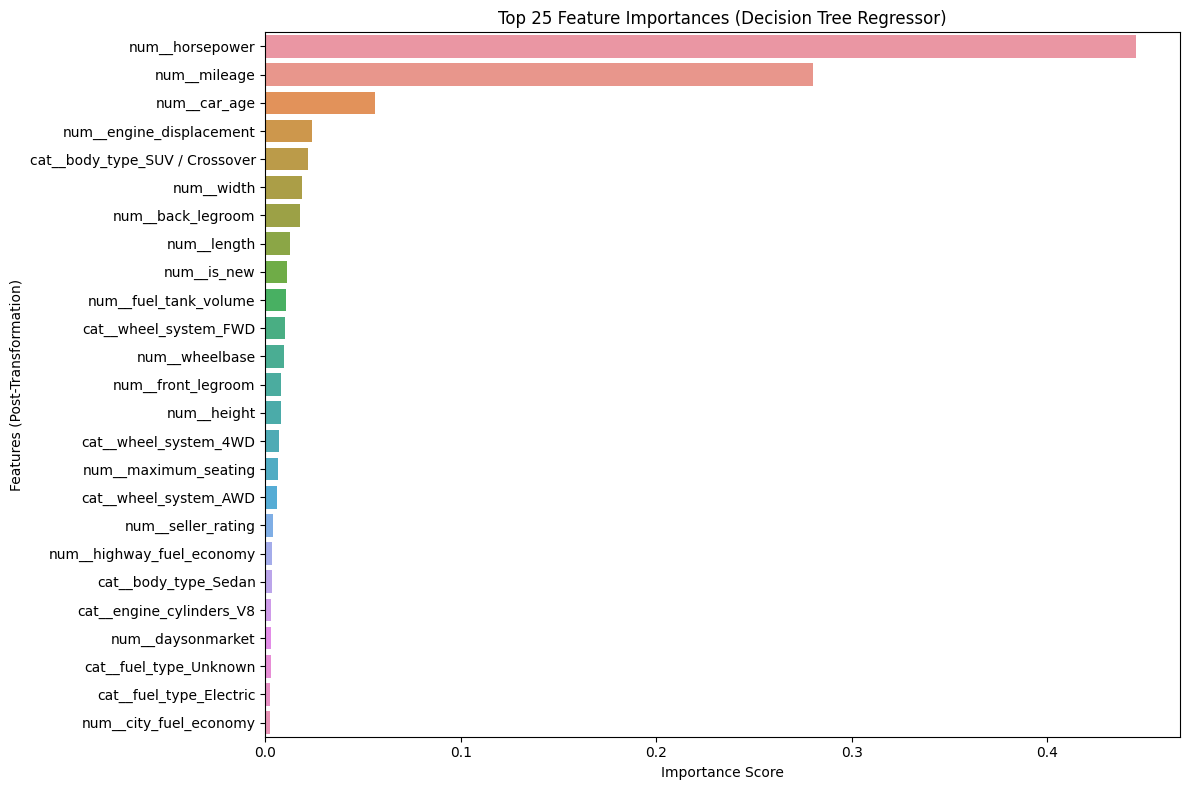


--- Decision Tree Analysis Complete ---


In [13]:
# --- Decision Tree ---
print("\n--- Decision Tree ---")
print("Training Decision Tree Regressor...")
start_time = time.time()
dt_model = DecisionTreeRegressor(random_state=RANDOM_STATE,
                                 max_depth=20,
                                 min_samples_leaf=20)
dt_model.fit(X_train_processed, y_train) # Train on processed training data
dt_train_time = time.time() - start_time
print(f"Decision Tree training completed in {dt_train_time:.2f} seconds.")

# Predict on Test Set
print("Predicting on test set...")
y_pred_dt = dt_model.predict(X_test_processed)

# Evaluate Model
print("\nDecision Tree Evaluation Metrics (on Test Set):")
dt_r2 = r2_score(y_test, y_pred_dt)
dt_mae = mean_absolute_error(y_test, y_pred_dt)
dt_mse = mean_squared_error(y_test, y_pred_dt)
dt_rmse = np.sqrt(dt_mse)
print(f"  R2 Score: {dt_r2:.4f}")
print(f"  Mean Absolute Error (MAE): {dt_mae:,.2f}")
print(f"  Root Mean Squared Error (RMSE): {dt_rmse:,.2f}")
print(f"  Accuracy: {dt_r2 * 100:.4f}")


# Feature Importance (based on model trained on X_train_processed)
dt_importances = pd.Series(dt_model.feature_importances_, index=feature_names_out).sort_values(ascending=False)
print(f"\nTop {N_TOP_FEATURES} Features (Decision Tree):")
print(dt_importances.head(N_TOP_FEATURES))

# Plot Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(x=dt_importances.head(N_TOP_FEATURES).values, y=dt_importances.head(N_TOP_FEATURES).index)
plt.title(f'Top {N_TOP_FEATURES} Feature Importances (Decision Tree Regressor)')
plt.xlabel('Importance Score')
plt.ylabel('Features (Post-Transformation)')
plt.tight_layout()
plt.show()

print("\n--- Decision Tree Analysis Complete ---")

# Random Forest


--- Random Forest ---
Training Random Forest Regressor...
Random Forest training completed in 928.70 seconds.
Predicting on test set...

Random Forest Evaluation Metrics (on Test Set):
  R2 Score: 0.9473
  Mean Absolute Error (MAE): 2,280.84
  Root Mean Squared Error (RMSE): 3,567.57
  Accuracy: 94.7286

Random Forest Out-of-Bag (OOB) R2 Score: 0.9474

Top 25 Features (Random Forest):
num__horsepower                   0.318202
num__mileage                      0.198565
num__car_age                      0.103914
num__fuel_tank_volume             0.059107
num__width                        0.044628
num__is_new                       0.037058
num__engine_displacement          0.032393
num__wheelbase                    0.024675
num__back_legroom                 0.016713
cat__wheel_system_FWD             0.016684
num__height                       0.014690
num__length                       0.014457
num__savings_amount               0.013293
num__maximum_seating              0.010512
cat__body

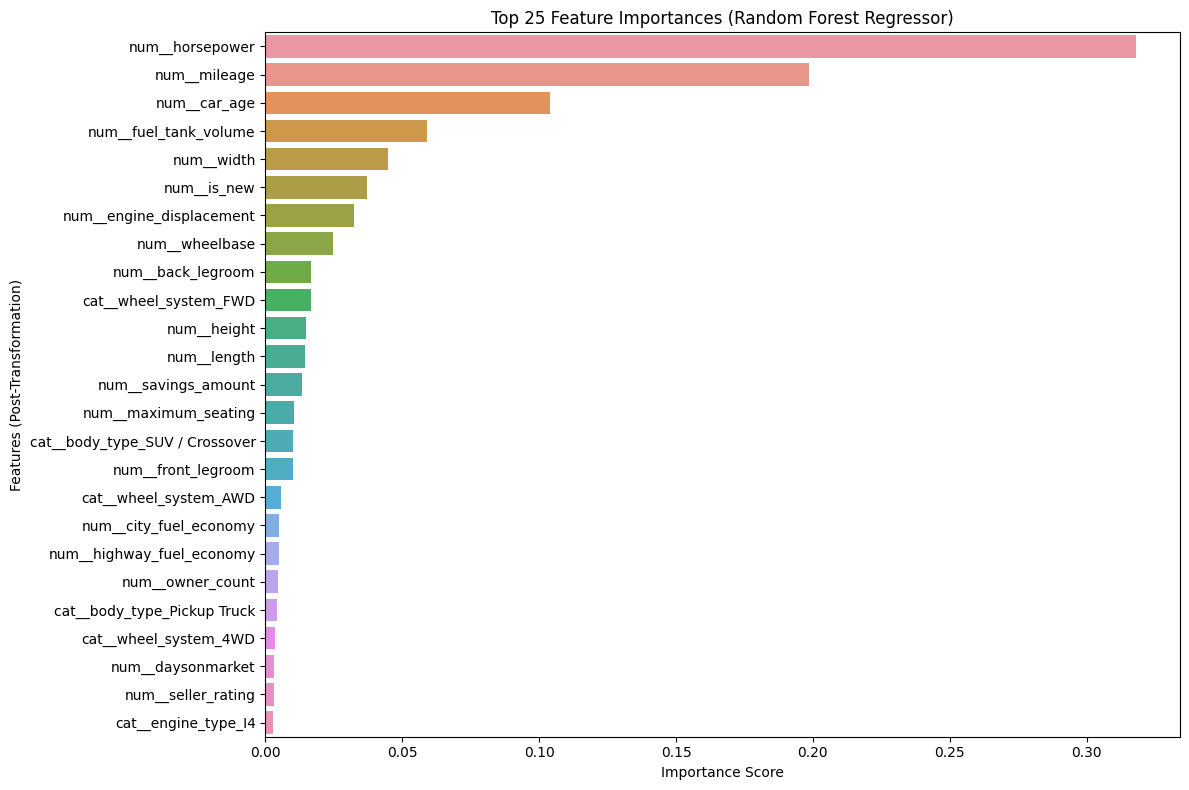


--- Random Forest Analysis Complete ---


In [14]:
# --- Random Forest ---
print("\n--- Random Forest ---")
print("Training Random Forest Regressor...")
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=100,
                                 random_state=RANDOM_STATE,
                                 n_jobs=-1,
                                 max_depth=20,
                                 min_samples_leaf=10,
                                 max_features=0.5,
                                 oob_score=True)
rf_model.fit(X_train_processed, y_train) # Train on processed training data
rf_train_time = time.time() - start_time
print(f"Random Forest training completed in {rf_train_time:.2f} seconds.")

# Predict on Test Set
print("Predicting on test set...")
y_pred_rf = rf_model.predict(X_test_processed)

# Evaluate Model
print("\nRandom Forest Evaluation Metrics (on Test Set):")
rf_r2 = r2_score(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
print(f"  R2 Score: {rf_r2:.4f}")
print(f"  Mean Absolute Error (MAE): {rf_mae:,.2f}")
print(f"  Root Mean Squared Error (RMSE): {rf_rmse:,.2f}")
print(f"  Accuracy: {rf_r2 * 100:.4f}")

# Display OOB Score (provides an estimate of R2 on unseen data during training)
if rf_model.oob_score_:
    print(f"\nRandom Forest Out-of-Bag (OOB) R2 Score: {rf_model.oob_score_:.4f}")


# Feature Importance (based on model trained on X_train_processed)
rf_importances = pd.Series(rf_model.feature_importances_, index=feature_names_out).sort_values(ascending=False)
print(f"\nTop {N_TOP_FEATURES} Features (Random Forest):")
print(rf_importances.head(N_TOP_FEATURES))


# Plot Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(x=rf_importances.head(N_TOP_FEATURES).values, y=rf_importances.head(N_TOP_FEATURES).index)
plt.title(f'Top {N_TOP_FEATURES} Feature Importances (Random Forest Regressor)')
plt.xlabel('Importance Score')
plt.ylabel('Features (Post-Transformation)')
plt.tight_layout()
plt.show()

print("\n--- Random Forest Analysis Complete ---")

# Neural Network


--- Neural Network ---
Num GPUs Available:  2
Neural Network Input Shape: 147


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,313 (114.50 KB)

 Trainable params: 29,313 (114.50 KB)

 Non-trainable params: 0 (0.00 B)


Training Neural Network for up to 50 epochs with Batch Size 512...
Using 20% of training data for validation during training.
Epoch 1/50
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 243417728.0000 - mean_absolute_error: 9990.9473 - mean_squared_error: 243417728.0000 - root_mean_squared_error: 14562.7461 - val_loss: 40530072.0000 - val_mean_absolute_error: 4311.6235 - val_mean_squared_error: 40530072.0000 - val_root_mean_squared_error: 6366.3232
Epoch 2/50
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 49909040.0000 - mean_absolute_error: 4914.7939 - mean_squared_error: 49909040.0000 - root_mean_squared_error: 7064.0781 - val_loss: 33085502.0000 - val_mean_absolute_error: 3860.9492 - val_mean_squared_error: 33085502.0000 - val_root_mean_squared_error: 5751.9995
Epoch 3/50
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 44694612.0000 - mean_absolute_error: 4627.5308 - mean_squared_error: 44694612.0000 - root_mean_squared_error: 6685.3330 - val_loss: 30384454.0000 - val_mea

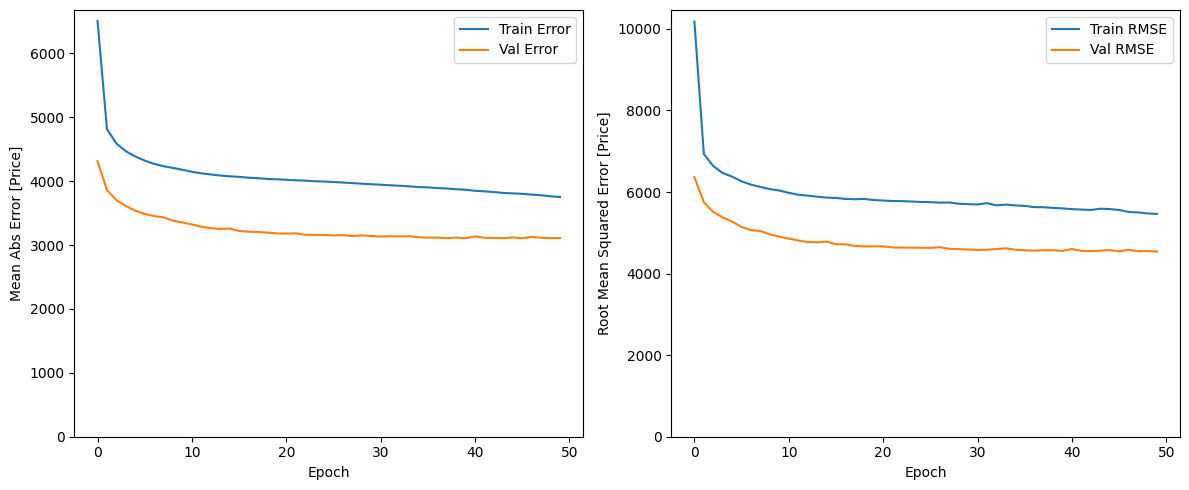


--- Neural Network Analysis Complete ---

--- ALL MODEL ANALYSES COMPLETE ---


In [15]:
# --- Neural Network (Keras/TensorFlow) ---
print("\n--- Neural Network ---")

# Check if GPU is available (recommended)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define the Neural Network Architecture
def build_nn_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)), # Define input shape explicitly
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3), # Add dropout for regularization
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1) # Output layer for regression (single value, linear activation)
    ])

    # Choose an optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile the model
    model.compile(loss='mean_squared_error', # Common loss for regression
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error', tf.keras.metrics.RootMeanSquaredError()]) # Track relevant metrics
    return model

# Get the input shape from the processed training data
input_shape = X_train_processed.shape[1]
print(f"Neural Network Input Shape: {input_shape}")

# Build the model
nn_model = build_nn_model(input_shape)

# Print model summary
nn_model.summary()

# --- Training Configuration ---
# !! Adjust these based on resources and convergence !!
EPOCHS = 50 # Start with a moderate number, EarlyStopping will halt if needed
BATCH_SIZE = 512 # Increase if memory allows (faster epochs), decrease if memory errors occur
VALIDATION_SPLIT = 0.2 # Use 20% of training data for validation during training

# Define Early Stopping callback
# Monitors 'val_loss' and stops training if it doesn't improve for 'patience' epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print(f"\nTraining Neural Network for up to {EPOCHS} epochs with Batch Size {BATCH_SIZE}...")
print(f"Using {VALIDATION_SPLIT*100:.0f}% of training data for validation during training.")

start_time = time.time()

# Train the model
# Ensure y_train is a NumPy array or compatible type
history = nn_model.fit(
    X_train_processed,
    np.array(y_train), # Convert y_train to numpy array just in case
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stopping],
    verbose=1 # Set to 1 or 2 to see progress per epoch, 0 for silent
)

nn_train_time = time.time() - start_time
print(f"Neural Network training completed in {nn_train_time:.2f} seconds.")

# --- Evaluate the Model on the Test Set ---
print("\nEvaluating Neural Network on Test Set...")
# The metrics specified during compile ('mae', 'mse', 'rmse') will be calculated
results = nn_model.evaluate(X_test_processed, np.array(y_test), batch_size=BATCH_SIZE, verbose=0) # Use test set

print("\nNeural Network Evaluation Metrics (on Test Set):")
# Map results to metric names based on model.metrics_names
for name, value in zip(nn_model.metrics_names, results):
    if name == 'loss': # Loss is MSE in this case
         print(f"  Mean Squared Error (Loss): {value:,.2f}")
    elif name == 'mean_absolute_error':
         print(f"  Mean Absolute Error (MAE): ${value:,.2f}")
    elif name == 'root_mean_squared_error':
         print(f"  Root Mean Squared Error (RMSE): ${value:,.2f}")
    else: # Print any other tracked metrics
         print(f"  {name}: {value:.4f}")

# Calculate R2 Score separately using sklearn
print("\nCalculating R2 Score...")
y_pred_nn = nn_model.predict(X_test_processed, batch_size=BATCH_SIZE).flatten() # Flatten prediction output
nn_r2 = r2_score(y_test, y_pred_nn)
print(f"  R2 Score: {nn_r2:.4f}")
print(f"  Accuracy: {nn_r2 * 100:.4f}")


# --- Optional: Plot Training History ---
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Price]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='Val Error')
    plt.ylim(bottom=0) # Adjust ylim if needed
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error [Price]')
    plt.plot(hist['epoch'], hist['root_mean_squared_error'], label='Train RMSE')
    plt.plot(hist['epoch'], hist['val_root_mean_squared_error'], label='Val RMSE')
    plt.ylim(bottom=0) # Adjust ylim if needed
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nPlotting Training History (MAE & RMSE)...")
plot_history(history)


print("\n--- Neural Network Analysis Complete ---")


print("\n--- ALL MODEL ANALYSES COMPLETE ---")